<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/Plant-disease/blob/master/DeteksiPenyakit_tanaman_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Plant Disease Diagnosis Model with PlantVillage Dataset

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('default')
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import keras
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.utils.data_utils import get_file

from keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Persiapan

## Pengambilan Data 

In [0]:
!apt-get install subversion > /dev/null

#Retreive specifc diseases of tomato for training
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Bacterial_spot image/Tomato___Bacterial_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Early_blight image/Tomato___Early_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Late_blight image/Tomato___Late_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Septoria_leaf_spot image/Tomato___Septoria_leaf_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Target_Spot image/Tomato___Target_Spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___healthy image/Tomato___healthy　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_mosaic_virus image/Tomato___mosaic_virus >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Spider_mites%20Two-spotted_spider_mite image/Tomato___Spider_mites_20Two-spotted_spider_mite >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Leaf_Mold image/Tomato___Leaf_Mold >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus image/Tomato___Yellow_Leaf_Curl_Virus >  /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cbb image/Cassava___cbb > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cbsd image/Cassava___cbsd > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cgm image/Cassava___cgm > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cmd image/Cassava___cmd > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/healthy image/Cassava___healthy > /dev/null

svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Bacterial_spot　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Early_blight　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Late_blight　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Septoria_leaf_spot　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Target_Spot　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___healthy　' already exists
svn: E155000: Destination directory exi

In [0]:
#folder structure
!ls image

Cassava___cbb		   Tomato___Late_blight　
Cassava___cbsd		   Tomato___Leaf_Mold
Cassava___cgm		   Tomato___mosaic_virus
Cassava___cmd		   Tomato___Septoria_leaf_spot　
Cassava___healthy	   Tomato___Spider_mites_20Two-spotted_spider_mite
Tomato___Bacterial_spot　  Tomato___Target_Spot　
Tomato___Early_blight　    Tomato___Yellow_Leaf_Curl_Virus
Tomato___healthy　


Tomato___Target_Spot　


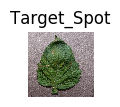

Cassava___cmd


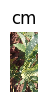

Tomato___Yellow_Leaf_Curl_Virus


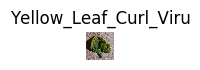

Tomato___healthy　


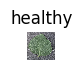

Tomato___Leaf_Mold


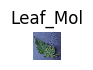

Tomato___Bacterial_spot　


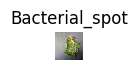

Tomato___mosaic_virus


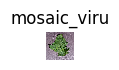

Tomato___Early_blight　


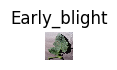

Cassava___cbsd


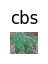

Cassava___healthy


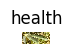

Tomato___Late_blight　


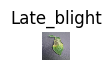

Cassava___cgm


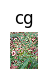

Tomato___Septoria_leaf_spot　


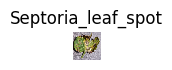

Tomato___Spider_mites_20Two-spotted_spider_mite


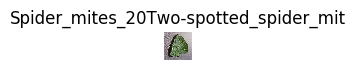

Cassava___cbb


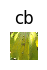

In [0]:
plt.figure(figsize=(15,10))

#visualize several images

parent_directory = "image"

for i, folder in enumerate(os.listdir(parent_directory)):
    print(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    file = files[0] 
    file_path = os.path.join(folder_directory,file)
    
    image = imread(file_path)
    plt.subplot(1,15,i+1)
    plt.imshow(image)
    plt.axis("off")
    
    name = folder.split("___")[1][:-1]
    plt.title(name)
    plt.show()

In [0]:
#load everything into memory
x = []
y = []
class_names = []
parent_directory = "image"

for i,folder in enumerate(os.listdir(parent_directory)):
    print(i,folder)
    class_names.append(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    for file in files:
        file_path = os.path.join(folder_directory,file)
        image = load_img(file_path,target_size=(64,64))
        image = img_to_array(image)/255.
        x.append(image)
        y.append(i)

x = np.array(x)
y = to_categorical(y)

0 Tomato___Target_Spot　
1 Cassava___cmd
2 Tomato___Yellow_Leaf_Curl_Virus
3 Tomato___healthy　
4 Tomato___Leaf_Mold
5 Tomato___Bacterial_spot　
6 Tomato___mosaic_virus
7 Tomato___Early_blight　
8 Cassava___cbsd
9 Cassava___healthy
10 Tomato___Late_blight　
11 Cassava___cgm
12 Tomato___Septoria_leaf_spot　
13 Tomato___Spider_mites_20Two-spotted_spider_mite
14 Cassava___cbb


In [0]:
#check the data shape
print(x.shape)
print(y.shape)
print(y[0])

(23816, 64, 64, 3)
(23816, 15)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
x_train, _x, y_train, _y = train_test_split(x,y,test_size=0.2, stratify = y, random_state = 1)
x_valid,x_test, y_valid, y_test = train_test_split(_x,_y,test_size=0.4, stratify = _y, random_state = 1)

print("train data:",x_train.shape,y_train.shape)
print("validation data:",x_valid.shape,y_valid.shape)
print("test data:",x_test.shape,y_test.shape)


train data: (19052, 64, 64, 3) (19052, 15)
validation data: (2858, 64, 64, 3) (2858, 15)
test data: (1906, 64, 64, 3) (1906, 15)


## Model Preparation

In [0]:
K.clear_session()

nfilter = 32


#VGG16 like model
model = Sequential([
    #feature extraction layer
    
    #block1
    layers.Conv2D(64,(3,3),padding="same",name="block1_conv1",input_shape=(64,64,3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64,(3,3),padding="same",name="block1_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block1_pool"),
    #block2
    layers.Conv2D(128,(3,3),padding="same",name="block2_conv1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128,(3,3),padding="same",name="block2_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block2_pool"),
    #block3
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv3"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block3_pool"),

    #block4
    layers.Conv2D(512,(3,3),padding="same",name="block4_conv1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(512,(3,3),padding="same",name="block4_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(512,(3,3),padding="same",name="block4_conv3"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block4_pool"),

    #block5
    layers.Conv2D(512,(3,3),padding="same",name="block5_conv1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(512,(3,3),padding="same",name="block5_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(512,(3,3),padding="same",name="block5_conv3"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block5_pool"),

    layers.Flatten(),
    
    #inference layer
    layers.Dense(512,name="fc1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(512,name="fc2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),    
    layers.Dropout(0.5),
    
    layers.Dense(15,name="prepredictions"),
    layers.Activation("softmax",name="predictions")
    
])

model.compile(optimizer = "adam", loss="categorical_crossentropy", metrics=["accuracy"])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




## Training

In [0]:
#utilize early stopping function to stop at the lowest validation loss
#es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#utilize save best weight model during training
ckpt = ModelCheckpoint("DeteksiPenyakitTanaman.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
#we will define a generator class for training data and validation data seperately, as no augmentation is not required for validation data
t_gen = ImageDataGenerator(rotation_range=90,horizontal_flip=True)
v_gen = ImageDataGenerator()
train_gen = t_gen.flow(x_train,y_train,batch_size=98)
valid_gen = v_gen.flow(x_valid,y_valid,batch_size=98)

In [0]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // 98,
    callbacks = [ckpt],
    #callbacks = [es,ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 98,
    
    epochs=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
194/194 [==============================] - 25s 128ms/step - loss: 1.5727 - acc: 0.4905 - val_loss: 3.4655 - val_acc: 0.2477

Epoch 00001: val_loss improved from inf to 3.46549, saving model to DeteksiPenyakitTanaman.hdf5
Epoch 2/50
194/194 [==============================] - 19s 100ms/step - loss: 0.9519 - acc: 0.6677 - val_loss: 2.9709 - val_acc: 0.4764

Epoch 00002: val_loss improved from 3.46549 to 2.97089, saving model to DeteksiPenyakitTanaman.hdf5
Epoch 3/50
194/194 [==============================] - 19s 100ms/step - loss: 0.7806 - acc: 0.7302 - val_loss: 2.4433 - val_acc: 0.4757

Epoch 00003: val_loss improved from 2.97089 to 2.44326, saving model to DeteksiPenyakitTanaman.hdf5
Epoch 4/50
194/194 [==============================] - 19s 100ms/step - loss: 0.6386 - acc: 0.7824 - val_loss: 2.1728 - val_acc: 0.5286

Epoch 00004: val_loss improved from 2.44326 to 2.17280, saving m

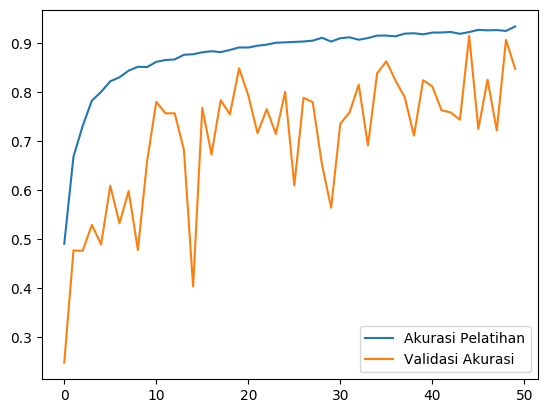

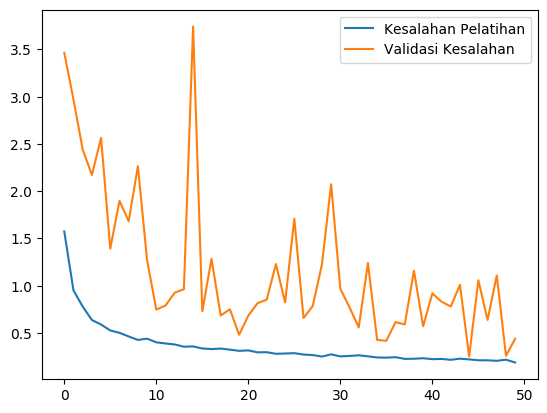

In [0]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

## Evaluation

In [0]:
#load the model weight file with lowest validation loss
model.load_weights("DeteksiPenyakitTanaman.hdf5")

In [0]:
#check the model metrics
print(model.metrics_names)
#evaluate training data
print(model.evaluate(x= x_train, y = y_train))
#evaluate  validation data
print(model.evaluate(x= x_valid, y = y_valid))
#evaluate  test data
print(model.evaluate(x= x_test, y = y_test))      

['loss', 'acc']
19052/19052 [==============================] - 8s 420us/step
[0.2251153258454667, 0.9217929876003349]
2858/2858 [==============================] - 1s 444us/step
[0.2666643894244275, 0.9111266619179781]
1906/1906 [==============================] - 1s 461us/step
[0.27815284755897923, 0.9087093389922399]


In [0]:
#draw a confusion matrix

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[ 2  3 10 ...  4  4  4]
[ 2  3 10 ...  4  4  4]


Normalized confusion matrix
[[0.99 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.88 0.   0.   0.   0.   0.   0.   0.03 0.01 0.   0.08 0.   0.
  0.  ]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.
  0.  ]
 [0.03 0.   0.01 0.   0.92 0.   0.   0.   0.   0.   0.   0.   0.   0.04
  0.  ]
 [0.   0.   0.01 0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.06 0.   0.   0.   0.   0.   0.   0.93 0.   0.   0.01 0.   0.   0.
  0.  ]
 [0.   0.19 0.   0.   0.   0.   0.   0.   0.66 0.06 0.   0.05 0.   0.
  0.04]
 [0.   0.12 0.   0.   0.   0.   0.   0.   0.04 0.64 0.   0.2  0.   0.
  0.  ]
 [0.   0.   0.   0.01 0.   0.01 0.   0.01 0.   0.   0.95 0.01 0.02 0.
  0.  ]
 [0.   0.29 0.   0.   0.   0.   0.   0.   0.08 0.11 0.   0.52 0.   0.
  0.  ]
 [0.02 0.   0.   0.   0.   0.01 0.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0.0, flags=flags)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0, flags=flags)


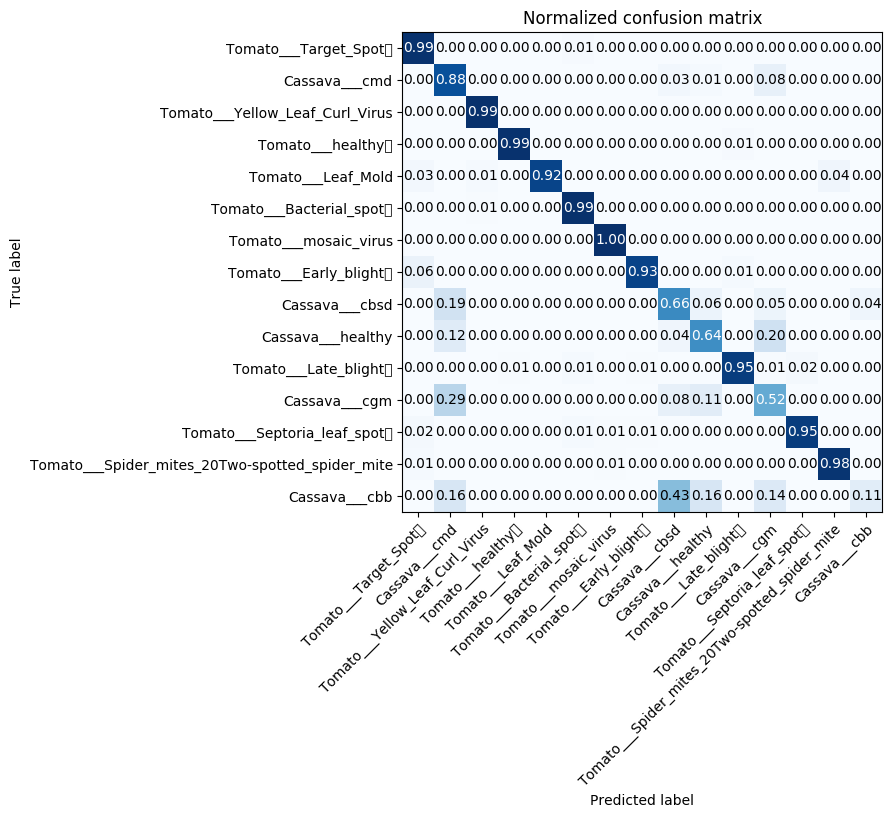

In [0]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



## Predicting Indivisual Images

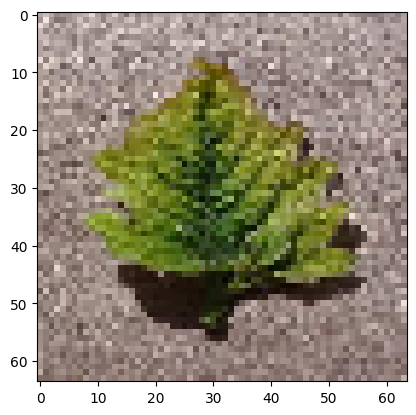

Gambar Yang Benar Adalah: 2 : Tomato___Yellow_Leaf_Curl_Virus
prediksi Value: [5.27e-09 1.89e-09 1.00e+00 2.71e-13 1.98e-08 1.82e-06 9.03e-09 2.40e-08
 1.15e-09 8.52e-12 1.53e-08 1.45e-10 1.08e-09 2.05e-06 1.33e-11]
prediksi gambar: 2 : Tomato___Yellow_Leaf_Curl_Virus
Prediksi Benar


In [0]:
n = 99 #do not exceed (number of test image - 1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("Gambar Yang Benar Adalah:",true_label,":",class_names[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("prediksi Value:",prediction)
predicted_label = np.argmax(prediction)
print("prediksi gambar:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("Prediksi Benar")
else:
    print("Prediksi Salah")

In [0]:
keras_file = "DeteksiPenyakitTanaman.hdf5"
tf.keras.models.save_model(model, keras_file)

# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("DeteksiPenyakitTanamanvgg16.tflite", "wb").write(tflite_model)